In [78]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path

## Visualization

In [79]:
# Constants
IMAGE_SIZE = (416, 416)  # Input size for YOLOv8
BATCH_SIZE = 16  # Number of samples per batch

In [98]:
# Path to the dataset
TRAIN_IMAGES_DIR = "dataset/train/images/"
TRAIN_LABELS_DIR = "dataset/train/labels/"

VAL_IMAGES_DIR = "dataset/val/images/"
VAL_LABELS_DIR = "dataset/val/labels/"


Validation images found: 0


In [99]:
from pathlib import Path

# Check if the validation images directory is correct
val_images_path = Path(VAL_IMAGES_DIR)

print("Validation images directory:", val_images_path)

# List all files in the directory to verify its contents
all_files = list(val_images_path.rglob("*"))  # List all files in the directory

print("All files in validation directory:", all_files)


Validation images directory: dataset\val\images
All files in validation directory: [WindowsPath('dataset/val/images/03615767-image_157.png'), WindowsPath('dataset/val/images/0f2b5ba0-image_485.png'), WindowsPath('dataset/val/images/129c4260-image_535.png'), WindowsPath('dataset/val/images/1a61703f-image_152.png'), WindowsPath('dataset/val/images/271a5681-image_182.png'), WindowsPath('dataset/val/images/2d2d735d-image_62.png'), WindowsPath('dataset/val/images/4bdc6164-image_149.png'), WindowsPath('dataset/val/images/6c677d97-image_32.png'), WindowsPath('dataset/val/images/8f1856a2-image_234.png'), WindowsPath('dataset/val/images/917e22ff-image_202.png'), WindowsPath('dataset/val/images/a726a48c-image_1.png'), WindowsPath('dataset/val/images/a9b526ae-image_315.png'), WindowsPath('dataset/val/images/ab0eb016-image_51.png'), WindowsPath('dataset/val/images/b16d8859-image_196.png'), WindowsPath('dataset/val/images/c0073a22-image_229.png'), WindowsPath('dataset/val/images/d5803ca0-image_150.

In [81]:
# Function to load and preprocess images
def load_image(image_path):
    if isinstance(image_path, tf.Tensor):  # Check if it's a TensorFlow tensor
        image_path = image_path.numpy().decode("utf-8")  # Convert to string
    image = Image.open(image_path).resize(IMAGE_SIZE)  # Resize
    image = np.array(image) / 255.0  # Normalize
    return image.astype(np.float32)

In [82]:
# Function to load and parse YOLO annotations
def load_yolo_annotations(label_path):
    if isinstance(label_path, tf.Tensor):
        label_path = label_path.numpy().decode("utf-8")
    
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert YOLO to bounding box format
            x_min = (x_center - width / 2) * IMAGE_SIZE[0]
            y_min = (y_center - height / 2) * IMAGE_SIZE[1]
            x_max = (x_center + width / 2) * IMAGE_SIZE[0]
            y_max = (x_center + height / 2) * IMAGE_SIZE[1]

            annotations.append([x_min, y_min, x_max, y_max, class_id])

    return np.array(annotations, dtype=np.float32)

In [83]:
# Function to load image and corresponding annotations
def load_sample(image_path):
    if isinstance(image_path, tf.Tensor):
        image_path = image_path.numpy().decode("utf-8")  # Explicit conversion to string
    
    image = load_image(image_path)
    label_path = TRAIN_LABELS_DIR + Path(image_path).stem + ".txt"  # Now label_path is a valid string
    annotations = load_yolo_annotations(label_path)
    return image, annotations


In [84]:
def data_loader(images_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg"))  # Get all image paths
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    # Map function to load images and annotations
    dataset = dataset.map(
        lambda x: tf.py_function(
            load_sample, [x], [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Apply batching and prefetching
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [85]:
# Create training dataset
train_dataset = data_loader(TRAIN_IMAGES_DIR, BATCH_SIZE)

# Test if the dataset can be iterated over without errors
for batch in train_dataset:
    images, labels = batch  # Verify the output
    print("Image batch shape:", images.shape)  # Should be (BATCH_SIZE, 416, 416, 3)
    print("Labels batch shape:", labels.shape)  # Varies based on annotations


Image batch shape: (1, 416, 416, 3)
Labels batch shape: (1, 1, 5)


In [26]:
# Install necessary visualization libraries
!pip install matplotlib

DEPRECATION: Loading egg at c:\users\acer\anaconda3\envs\object_detection\lib\site-packages\avro_python3-1.10.2-py3.9.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [44]:
import keras_cv
import matplotlib.pyplot as plt
import keras_cv.visualization as visualization

In [86]:
# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[..., -1]  # The last element is the class ID
        bounding_boxes = bounding_boxes_raw[..., :-1]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return bounding_boxes, class_ids

In [87]:
# Function to normalize image data
def normalize_image_data(image):
    # Convert TensorFlow tensor to NumPy array
    image = image.numpy()  # Explicit conversion
    # If data is in float format, scale to [0, 255]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
    return image


In [88]:
# Function to convert from BGR to RGB if needed
def ensure_rgb_format(image):
    # If the image appears incorrect, try converting BGR to RGB
    if image.shape[-1] == 3:  # Assuming three channels (RGB or BGR)
        return image[..., ::-1]  # Reverse the color channels to convert BGR to RGB
    return image


In [89]:
# Visualization function to plot bounding boxes with proper normalization
def visualize_dataset(dataset, value_range, default_rows, default_cols, bounding_box_format):
    # Get the first batch from the dataset
    batch = next(iter(dataset.take(1)))  # Get the first batch
    
    # Extract images and raw bounding boxes
    images, bounding_boxes_raw = batch
    
    # Normalize image data and ensure correct color space
    # Convert TensorFlow tensors to NumPy arrays before applying NumPy operations
    images = np.array([normalize_image_data(img) for img in images])
    images = np.array([ensure_rgb_format(img) for img in images])
    
    # Ensure there are images to plot
    if images.shape[0] == 0:
        raise ValueError("No images found in the dataset.")

    # Adjust rows and columns based on available images
    total_images = images.shape[0]
    rows = min(default_rows, total_images)
    cols = math.ceil(total_images / rows)

    # Extract bounding boxes and class IDs
    bounding_boxes, class_ids = extract_bounding_box_info(bounding_boxes_raw)

    # Convert bounding box format
    bounding_boxes = keras_cv.bounding_box.convert_format(
        bounding_boxes,
        source=bounding_box_format,
        target="xywh",
    )

    # Create class mappings for visualization
    class_mapping = {int(cls): f"Class {cls}" for cls in np.unique(class_ids)}
    
    # Plot bounding boxes on images
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true={
            "classes": class_ids,
            "boxes": bounding_boxes,
        },
        scale=5,
        font_scale=0.7,
        bounding_box_format="xywh",
        class_mapping=class_mapping,
    )

In [90]:
import math

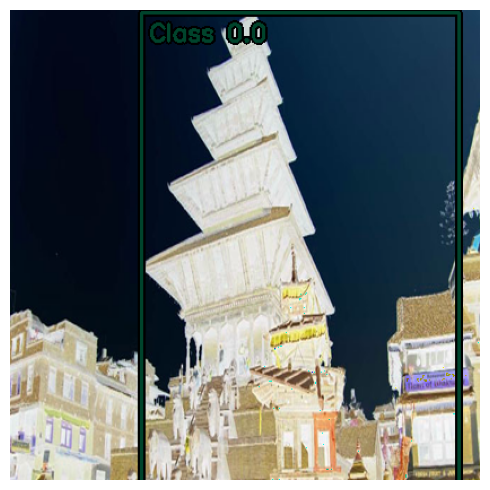

In [91]:
# Create training dataset
train_dataset = data_loader(TRAIN_IMAGES_DIR, BATCH_SIZE)

# Test visualization with updated dynamic row/column size
visualize_dataset(train_dataset, value_range=(0, 1), default_rows=2, default_cols=2, bounding_box_format="xywh")


In [92]:
# Create training dataset
train_dataset = data_loader(TRAIN_IMAGES_DIR, BATCH_SIZE)

# Retrieve the first batch to inspect
first_batch = next(iter(train_dataset.take(1)))
images, bounding_boxes = first_batch

# Display the shapes of the outputs
print("Images shape:", images.shape)  # Should be (BATCH_SIZE, height, width, channels)
print("Bounding boxes shape:", bounding_boxes.shape)  # Expected (BATCH_SIZE, num_boxes, 5 or 4)


Images shape: (1, 416, 416, 3)
Bounding boxes shape: (1, 1, 5)


In [97]:
val_dataset = data_loader(VAL_IMAGES_DIR, BATCH_SIZE)
# Ensure the dataset is not empty
num_records = sum(1 for _ in val_dataset)
print("Number of records in the validation dataset:", num_records)

# Ensure the dataset is properly initialized
if num_records == 0:
    raise ValueError("The validation dataset is empty or not initialized correctly.")

Number of records in the validation dataset: 0


ValueError: The validation dataset is empty or not initialized correctly.

In [96]:
# Visualize the validation dataset
visualize_dataset(
    val_dataset,
    value_range=(0, 1),
    default_rows=2,  # Adjust rows based on your dataset
    default_cols=2,  # Adjust columns based on your dataset
    bounding_box_format="xywh",  # Ensure correct bounding box format
)


StopIteration: 